In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'
biogrid = '../out/biogrid.all.txt'
biogrid_genetic = '../out/biogrid.genetic.txt'
threshold = 0.1

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')

plt.rc('font', size=12)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
import itertools
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

In [4]:
def compare(w, df,
            iterations=10,
            name='',
            threshold=0.1):
    idx = df.index.intersection(w.index)

    y = w.loc[idx]
    df = df.loc[idx]

    res = []
    for x in df.loc[y[y > threshold].index].values:
        res.append((name, 'real', x))
    for i in range(iterations):
        for x in df.loc[y[y <= threshold].sample(n=y[y > threshold].shape[0]).index]:
            res.append((name, 'random%d' % i, x))
    r = pd.DataFrame(res,
                     columns=['name', 'set', 'v'])

    return r

In [5]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [6]:
it = {}
for l in open(biogrid):
    g1, g2 = l.rstrip().split()
    it[g1] = it.get(g1, 0)
    it[g2] = it.get(g2, 0)
    it[g1] += 1
    it[g2] += 1

In [7]:
gi = pd.read_table(biogrid_genetic)
git = {}
for g1, g2 in gi[(gi['interaction'] == 'negative') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    git[g1] = git.get(g1, 0)
    git[g2] = git.get(g2, 0)
    git[g1] += 1
    git[g2] += 1
pit = {}
for g1, g2 in gi[(gi['interaction'] == 'positive') &
                 (gi['count'] >= 2)][['gene1', 'gene2']].values:
    pit[g1] = pit.get(g1, 0)
    pit[g2] = pit.get(g2, 0)
    pit[g1] += 1
    pit[g2] += 1

In [8]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']
pgenes = m.loc[(slice(None), genes),].groupby('gene')['phenotype'].max()
pgenes = set(pgenes[pgenes == True].index)

S288C 4889
Y55 4190
YPS 4093
UWOP 4014

total 3786


In [9]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index()

In [10]:
strains = {y
           for x in d.index
           for y in x[:2]}

In [11]:
r = (d[d['qvalue'] < 0.01].groupby(['strain1', 'strain2', 'gene'])[
     'phenotype1'].sum() / d.groupby(['strain1', 'strain2', 'gene'])[
     'phenotype1'].sum()).dropna().reset_index().rename(
    columns={'strain1': 'strain',
             'strain2': 'other',
             'phenotype1': 'deviations'})
s = (d[d['qvalue'] < 0.01].groupby(['strain2', 'strain1', 'gene'])[
     'phenotype2'].sum() / d.groupby(['strain2', 'strain1', 'gene'])[
     'phenotype2'].sum()).dropna().reset_index().rename(
    columns={'strain2': 'strain',
             'strain1': 'other',
             'phenotype2': 'deviations'})
t = pd.concat([r, s], sort=False).set_index(['strain', 'other', 'gene'])
t = t.reindex([(x, y, g)
              for x, y, in itertools.product(strains, strains)
              if x != y
              for g in pgenes],
              fill_value=0)['deviations']
w = t.groupby(['gene']).mean()

In [12]:
it = pd.Series(it)
git = pd.Series(git)
pit = pd.Series(pit)

it = it / it.max()
git = git / git.max()
pit = pit / pit.max()

In [13]:
res = []
for df, name in zip([it,
                     git, pit],
                    ['biogrid',
                     'genetic-negative',
                     'genetic-positive']):
    res.append(compare(w, df, name=name,
                       threshold=threshold))
r = pd.concat(res)

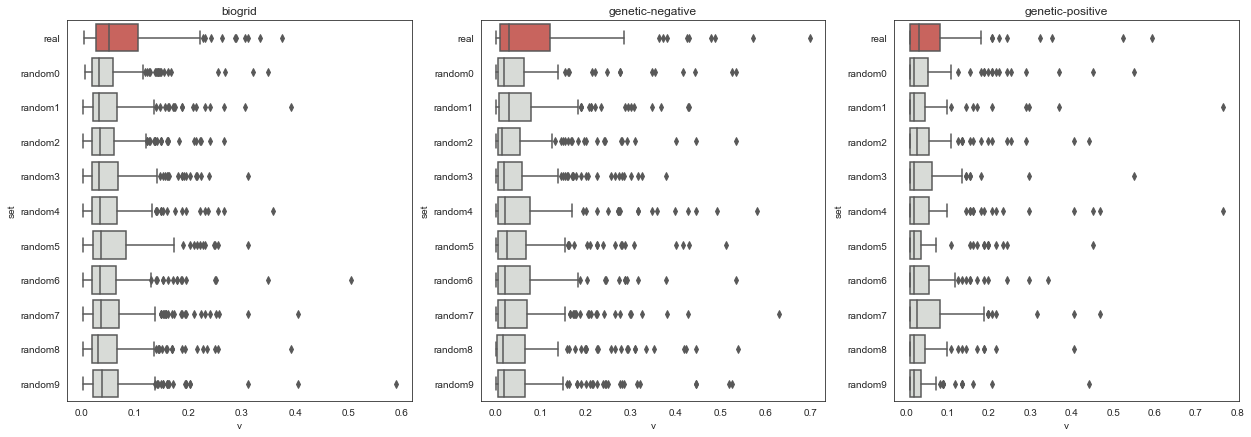

In [14]:
plt.figure(figsize=(21, 7))

for i, name in enumerate(r['name'].unique()):
    plt.subplot(1, 3, i+1)
    
    sns.boxplot(data=r[r['name'] == name],
                x='v',
                y='set',
                palette=[sns.xkcd_rgb['pale red']] +
                        [sns.xkcd_rgb['light grey']] * 10)
    
    plt.title(name);

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


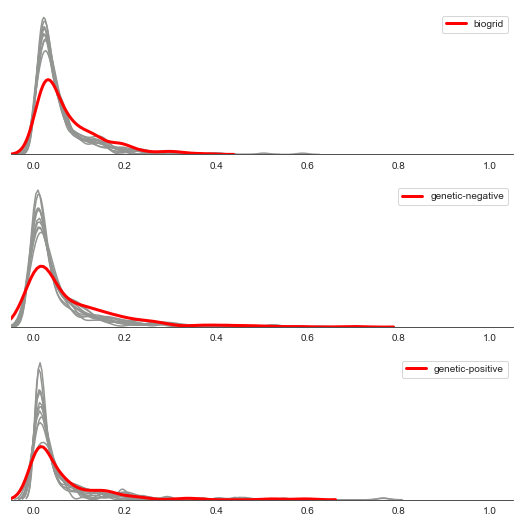

In [15]:
plt.figure(figsize=(9, 9))

for i, name in enumerate(r['name'].unique()):
    plt.subplot(3, 1, i+1)
    
    sns.kdeplot(r[(r['name'] == name) &
                  (r['set'] == 'real')]['v'],
                color='r',
                label=name,
                lw=3)
    for x in r[(r['name'] == name) &
               (r['set'] != 'real')]['set'].unique():
        sns.kdeplot(r[(r['name'] == name) &
                      (r['set'] == x)]['v'],
                    color=sns.xkcd_rgb['grey'],
                    label='_',
                    zorder=0)
    
    plt.xlim(-0.05, 1.05)
    plt.yticks([])
    
sns.despine(left=True)

In [16]:
res = []
for df, name in zip([it,
                     git, pit],
                    ['biogrid',
                     'genetic-negative',
                     'genetic-positive']):
    res.append(compare(w, df, name=name, iterations=100,
                       threshold=threshold))
r = pd.concat(res)

In [17]:
res = []
for name in r['name'].unique():
    v1 = r[(r['name'] == name) &
          (r['set'] == 'real')]['v']
    for x in r[(r['name'] == name) &
               (r['set'] != 'real')]['set'].unique():
        v2 = r[(r['name'] == name) &
               (r['set'] == x)]['v']
        stat, pval = stats.ks_2samp(v1, v2)
        res.append((name, stat, pval))
p = pd.DataFrame(res,
                 columns=['name', 'stat', 'pval'])
p['qval'] = sm.stats.multipletests(p['pval'],
                                   method='fdr_bh')[1]

In [18]:
p.groupby('name')['qval'].describe()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
biogrid,100.0,0.005667,0.010094,0.000654,0.001126,0.002812,0.005875,0.088548
genetic-negative,100.0,0.023725,0.030545,0.000654,0.005384,0.014789,0.032466,0.215880
genetic-positive,100.0,0.239346,0.224647,0.003573,0.076867,0.191964,0.315944,0.912810
